## 미션
이번 미션에서는  모델을 활용하여 FashionMNIST 데이터셋의 각 패션 아이템(예: 티셔츠, 바지, 스니커즈 등)을 조건부로 생성하는 작업을 수행합니다. 각 클래스에 해당하는 이미지를 생성하는 cGAN (Conditional GAN) 모델을 직접 설계하고 학습시켜 보세요.

## 데이터 소개
데이터 링크: torchvision.datasets.FashionMNIST를 통해 바로 다운로드 가능
<br>데이터 구성:
- 훈련 데이터: 60,000장의 이미지
- 테스트 데이터: 10,000장의 이미지
- 28×28 크기의 흑백 이미지 (10개 클래스)
### 클래스 목록:
- T-shirt/top
- Trouser
- Pullover
- Dress
- Coat
- Sandal
- Shirt
- Sneaker
- Bag
- Ankle boot

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

In [5]:
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
# 클래스
idx_class = {i : class_name for i, class_name in enumerate(dataset.classes)}
idx_class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [7]:
n_classes = 10

In [8]:
images, labels = next(iter(dataloader))
images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [9]:
img_size = 28 
latent_dim = 50     # 잠재 공간 차원

In [10]:
# Generator(생성자)
class Generator(nn.Module):
    def __init__(self, latent_dim, n_classes, img_size):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, latent_dim)
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(latent_dim * 2, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, img_size * img_size),
            nn.Tanh()
        )
        

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat([noise, label_input], dim=1)
        out = self.model(gen_input)
        return out.view(out.size(0), 1, img_size, img_size)

In [11]:
# Discriminator(판별자)
class Discriminator(nn.Module):
    def __init__(self, n_classes, img_size):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, img_size * img_size)
        self.img_size = img_size

        self.model = nn.Sequential(
            nn.Linear(img_size * img_size * 2, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_emb(labels).view(labels.size(0), 1, img_size, img_size)
        d = torch.cat([img, label_input], dim=1)
        d_flat = d.view(d.size(0), -1)
        return self.model(d_flat)

In [12]:
G = Generator(latent_dim, n_classes, img_size).to(device)
D = Discriminator(n_classes, img_size).to(device)

In [13]:
criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
epochs = 100

In [14]:
def show_real_fake(real_imgs, fake_imgs, num_images=8):
    """
    실제 이미지와 Generator가 생성한 이미지 나란히 출력
    """
    # 역정규화: [-1, 1] → [0, 1]
    real_imgs = (real_imgs + 1) / 2
    fake_imgs = (fake_imgs + 1) / 2

    real_imgs = real_imgs[:num_images].cpu()
    fake_imgs = fake_imgs[:num_images].cpu()

    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 1.5, 3))
    for i in range(num_images):
        axes[0, i].imshow(real_imgs[i].squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(fake_imgs[i].squeeze(), cmap='gray')
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel("Real", fontsize=14)
    axes[1, 0].set_ylabel("Fake", fontsize=14)
    plt.tight_layout()
    plt.show()

In [15]:
g_losses = []
d_losses = []
d_accuracies = []

Epoch [1/100]  D loss: 0.6865  G loss: 0.6544  D acc: 0.5469
Epoch [2/100]  D loss: 0.6748  G loss: 0.8074  D acc: 0.5156
Epoch [3/100]  D loss: 0.6733  G loss: 0.7534  D acc: 0.5938
Epoch [4/100]  D loss: 0.7216  G loss: 0.7180  D acc: 0.4844
Epoch [5/100]  D loss: 0.7003  G loss: 0.8824  D acc: 0.5781


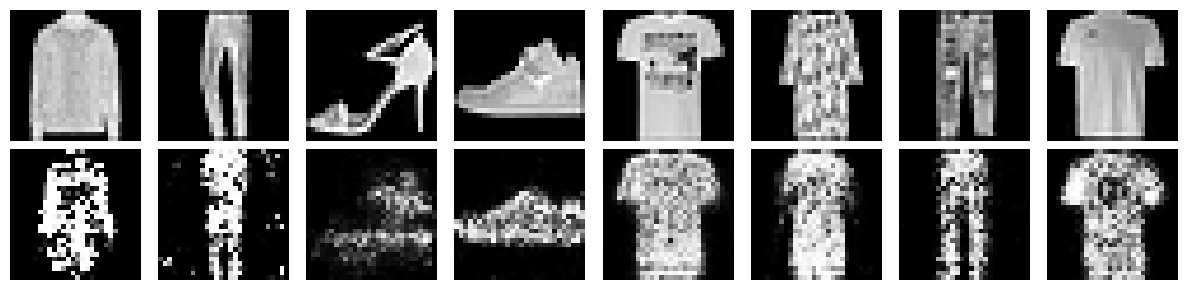

Epoch [6/100]  D loss: 0.7191  G loss: 0.7649  D acc: 0.4531
Epoch [7/100]  D loss: 0.6716  G loss: 0.6785  D acc: 0.5312
Epoch [8/100]  D loss: 0.7142  G loss: 0.8309  D acc: 0.4688
Epoch [9/100]  D loss: 0.6519  G loss: 0.8490  D acc: 0.6406
Epoch [10/100]  D loss: 0.6724  G loss: 0.6935  D acc: 0.5938


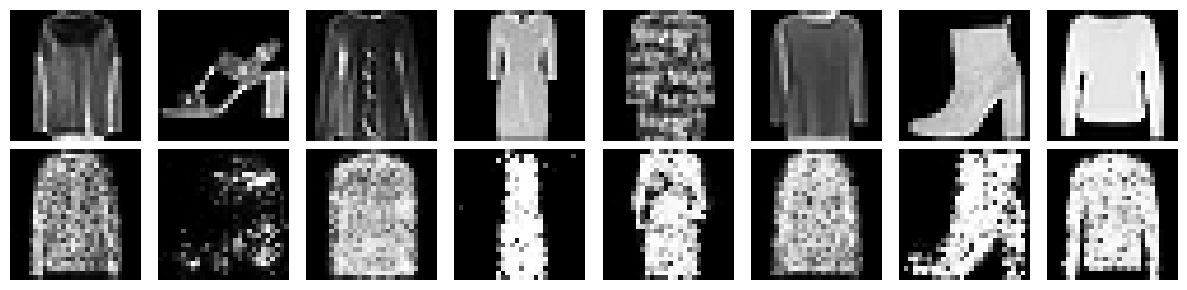

Epoch [11/100]  D loss: 0.7047  G loss: 0.6242  D acc: 0.5781
Epoch [12/100]  D loss: 0.7005  G loss: 0.7647  D acc: 0.5469
Epoch [13/100]  D loss: 0.6829  G loss: 0.7221  D acc: 0.5469
Epoch [14/100]  D loss: 0.6320  G loss: 0.8097  D acc: 0.6719
Epoch [15/100]  D loss: 0.6680  G loss: 0.7041  D acc: 0.5781


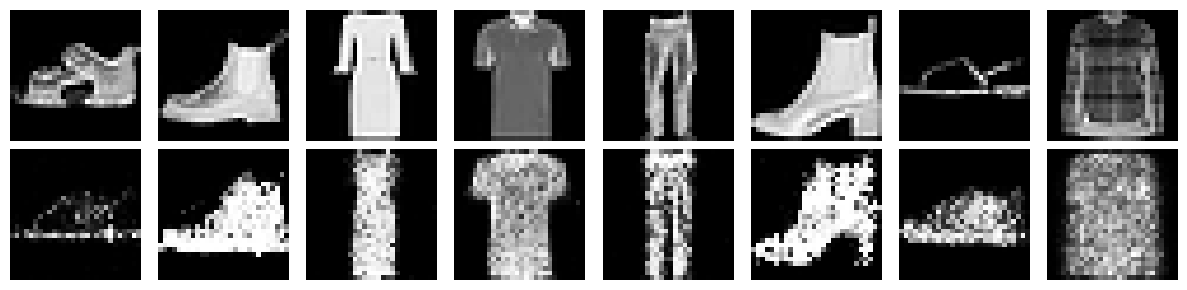

Epoch [16/100]  D loss: 0.6872  G loss: 0.7933  D acc: 0.5312
Epoch [17/100]  D loss: 0.6463  G loss: 0.7559  D acc: 0.6562
Epoch [18/100]  D loss: 0.6917  G loss: 0.7416  D acc: 0.4844
Epoch [19/100]  D loss: 0.7118  G loss: 0.6823  D acc: 0.5312
Epoch [20/100]  D loss: 0.7074  G loss: 0.7049  D acc: 0.4688


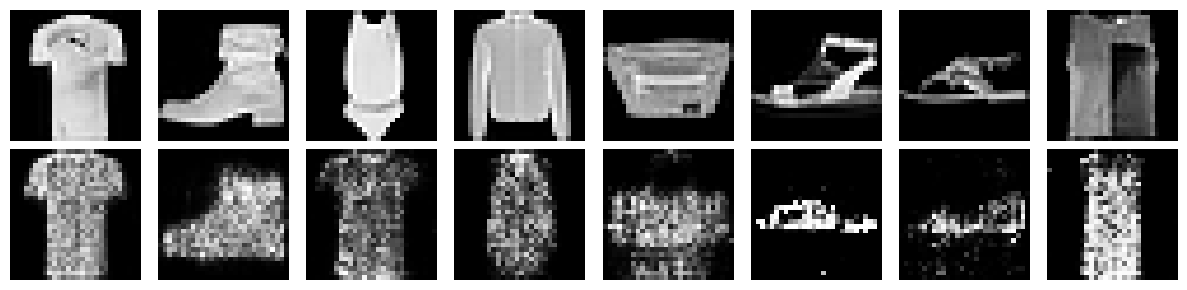

Epoch [21/100]  D loss: 0.6999  G loss: 0.8466  D acc: 0.5625
Epoch [22/100]  D loss: 0.7041  G loss: 0.8010  D acc: 0.5156
Epoch [23/100]  D loss: 0.7434  G loss: 0.7963  D acc: 0.4688
Epoch [24/100]  D loss: 0.6627  G loss: 0.7230  D acc: 0.5000
Epoch [25/100]  D loss: 0.7146  G loss: 0.8111  D acc: 0.4375


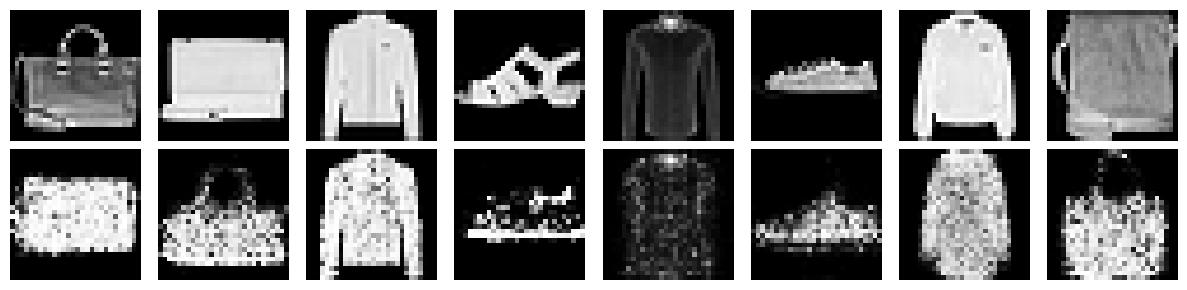

Epoch [26/100]  D loss: 0.7212  G loss: 1.0333  D acc: 0.5781
Epoch [27/100]  D loss: 0.6828  G loss: 0.7301  D acc: 0.5000
Epoch [28/100]  D loss: 0.6996  G loss: 0.8490  D acc: 0.5469
Epoch [29/100]  D loss: 0.6733  G loss: 0.6012  D acc: 0.5938
Epoch [30/100]  D loss: 0.6893  G loss: 0.8004  D acc: 0.5625


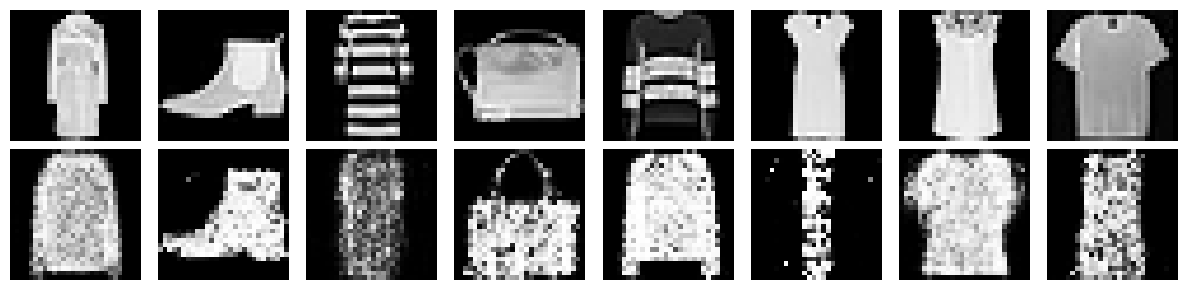

Epoch [31/100]  D loss: 0.7239  G loss: 0.7800  D acc: 0.4844
Epoch [32/100]  D loss: 0.7279  G loss: 0.7885  D acc: 0.4062
Epoch [33/100]  D loss: 0.7108  G loss: 0.5043  D acc: 0.4531
Epoch [34/100]  D loss: 0.7157  G loss: 0.7570  D acc: 0.5469
Epoch [35/100]  D loss: 0.7049  G loss: 0.7124  D acc: 0.4219


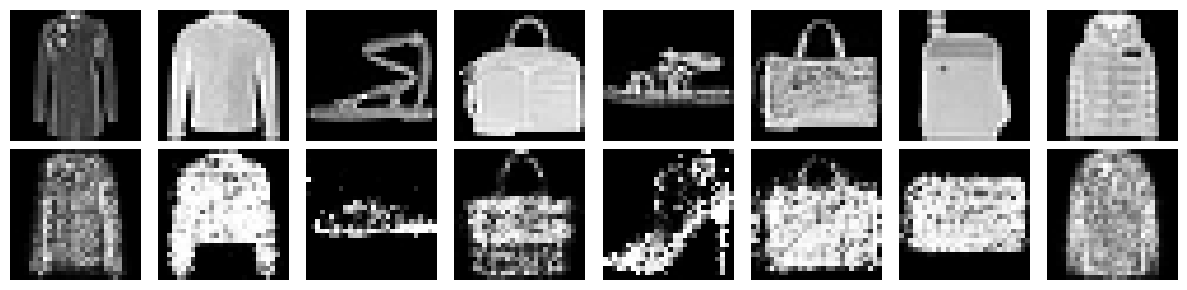

Epoch [36/100]  D loss: 0.7321  G loss: 0.8057  D acc: 0.5625
Epoch [37/100]  D loss: 0.6810  G loss: 0.8749  D acc: 0.6250
Epoch [38/100]  D loss: 0.6819  G loss: 0.6568  D acc: 0.5781
Epoch [39/100]  D loss: 0.6611  G loss: 0.8202  D acc: 0.5781
Epoch [40/100]  D loss: 0.6913  G loss: 0.8152  D acc: 0.5781


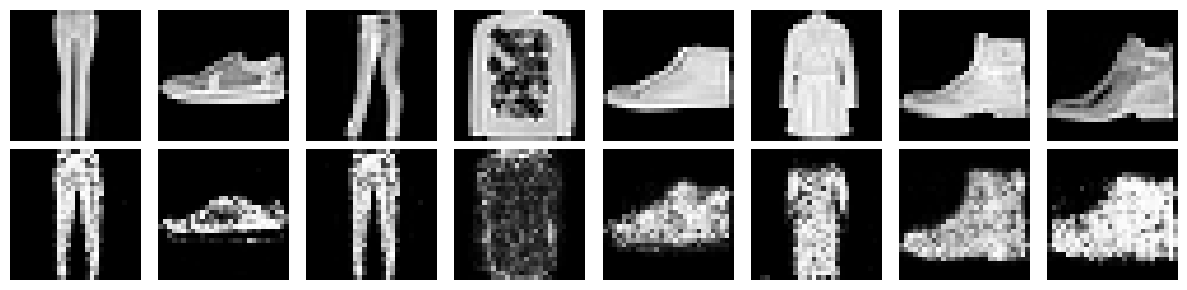

Epoch [41/100]  D loss: 0.7112  G loss: 0.7219  D acc: 0.4844
Epoch [42/100]  D loss: 0.6768  G loss: 0.6881  D acc: 0.5781
Epoch [43/100]  D loss: 0.7107  G loss: 0.8440  D acc: 0.5312
Epoch [44/100]  D loss: 0.7298  G loss: 0.8107  D acc: 0.5312
Epoch [45/100]  D loss: 0.6990  G loss: 0.8346  D acc: 0.5469


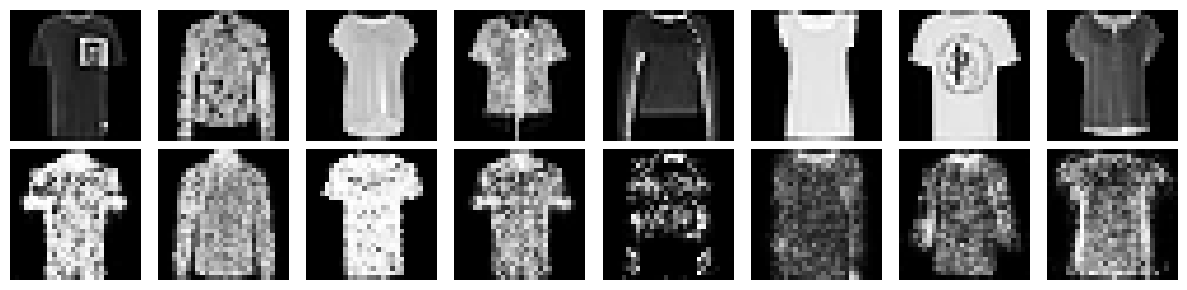

Epoch [46/100]  D loss: 0.7013  G loss: 0.7942  D acc: 0.5156
Epoch [47/100]  D loss: 0.6777  G loss: 0.8473  D acc: 0.6250
Epoch [48/100]  D loss: 0.6694  G loss: 0.8494  D acc: 0.5312
Epoch [49/100]  D loss: 0.6573  G loss: 0.8742  D acc: 0.6406
Epoch [50/100]  D loss: 0.7251  G loss: 0.4949  D acc: 0.5156


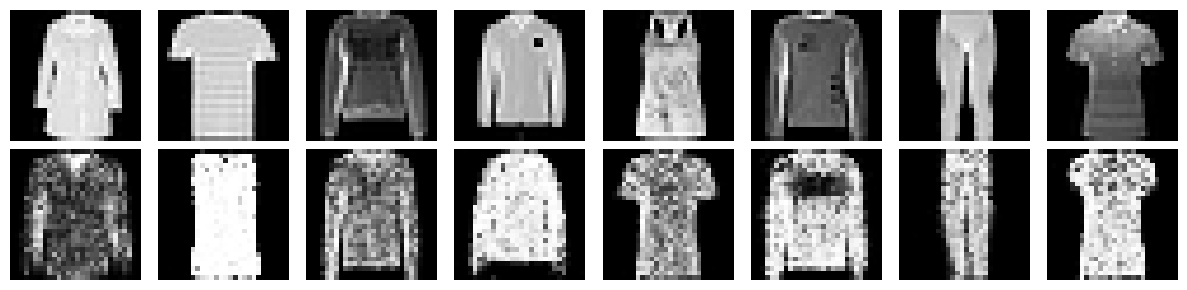

Epoch [51/100]  D loss: 0.6629  G loss: 0.7615  D acc: 0.5938
Epoch [52/100]  D loss: 0.7277  G loss: 0.8252  D acc: 0.4844
Epoch [53/100]  D loss: 0.7206  G loss: 0.6507  D acc: 0.5312
Epoch [54/100]  D loss: 0.6442  G loss: 0.7027  D acc: 0.6250
Epoch [55/100]  D loss: 0.6981  G loss: 0.7636  D acc: 0.5156


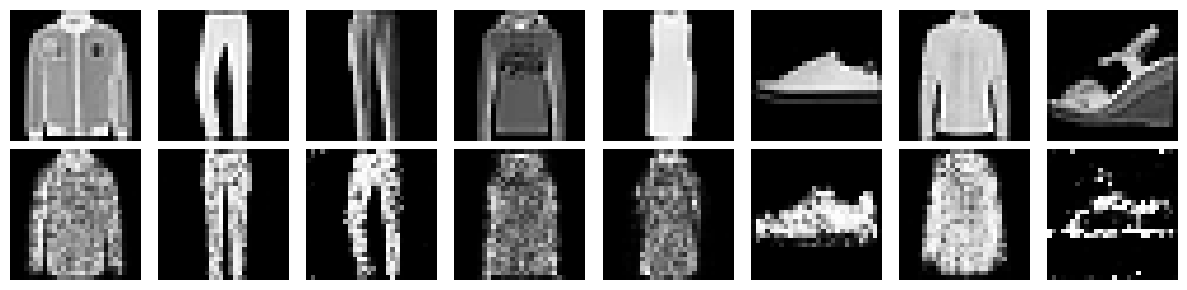

Epoch [56/100]  D loss: 0.6777  G loss: 0.5611  D acc: 0.5781
Epoch [57/100]  D loss: 0.6841  G loss: 0.8624  D acc: 0.6406
Epoch [58/100]  D loss: 0.6735  G loss: 0.6597  D acc: 0.5469
Epoch [59/100]  D loss: 0.6887  G loss: 0.7061  D acc: 0.5312
Epoch [60/100]  D loss: 0.7264  G loss: 0.7568  D acc: 0.5000


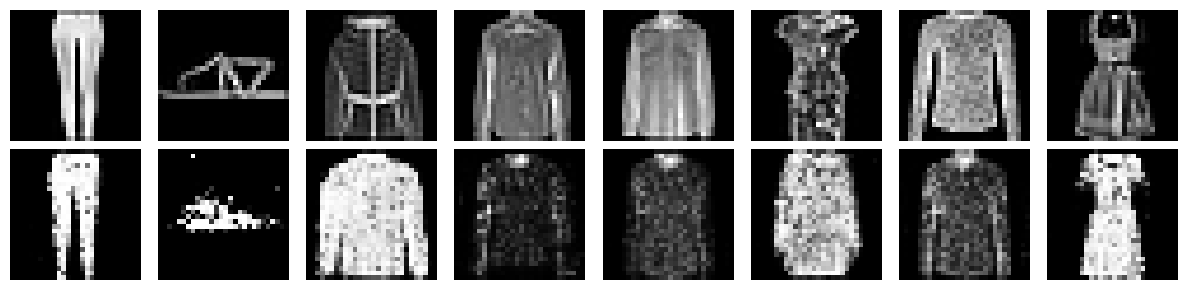

Epoch [61/100]  D loss: 0.6905  G loss: 0.6886  D acc: 0.5469
Epoch [62/100]  D loss: 0.6845  G loss: 0.7655  D acc: 0.5469
Epoch [63/100]  D loss: 0.6228  G loss: 0.8679  D acc: 0.6562
Epoch [64/100]  D loss: 0.6881  G loss: 1.0455  D acc: 0.5312
Epoch [65/100]  D loss: 0.6673  G loss: 0.6981  D acc: 0.5781


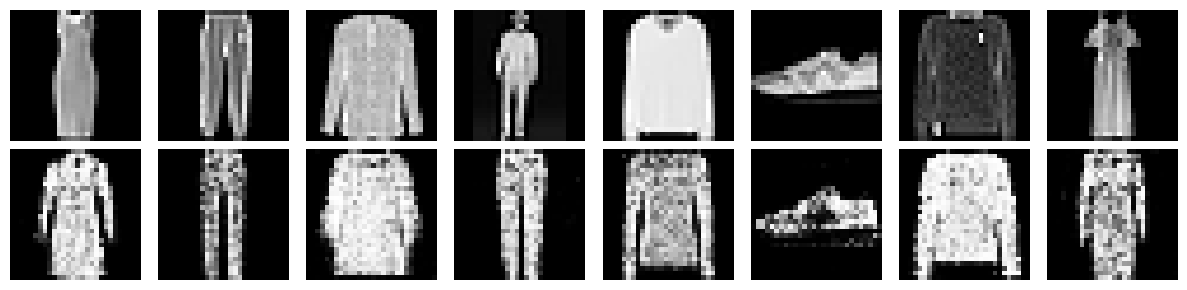

Epoch [66/100]  D loss: 0.7181  G loss: 0.7801  D acc: 0.5312
Epoch [67/100]  D loss: 0.6750  G loss: 0.7624  D acc: 0.5781
Epoch [68/100]  D loss: 0.7317  G loss: 0.7210  D acc: 0.4688
Epoch [69/100]  D loss: 0.6565  G loss: 0.9250  D acc: 0.5469
Epoch [70/100]  D loss: 0.6313  G loss: 0.9569  D acc: 0.5469


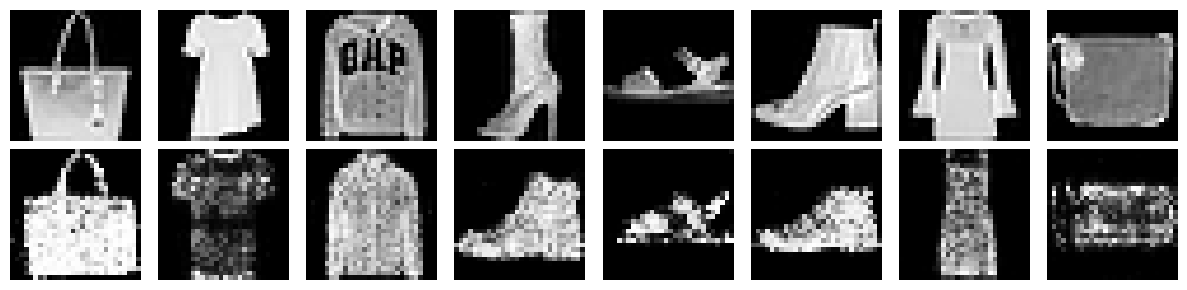

Epoch [71/100]  D loss: 0.6570  G loss: 0.7264  D acc: 0.5625
Epoch [72/100]  D loss: 0.7024  G loss: 0.7216  D acc: 0.5625
Epoch [73/100]  D loss: 0.6830  G loss: 1.0043  D acc: 0.6094
Epoch [74/100]  D loss: 0.7265  G loss: 0.9403  D acc: 0.5312
Epoch [75/100]  D loss: 0.7053  G loss: 0.7522  D acc: 0.5156


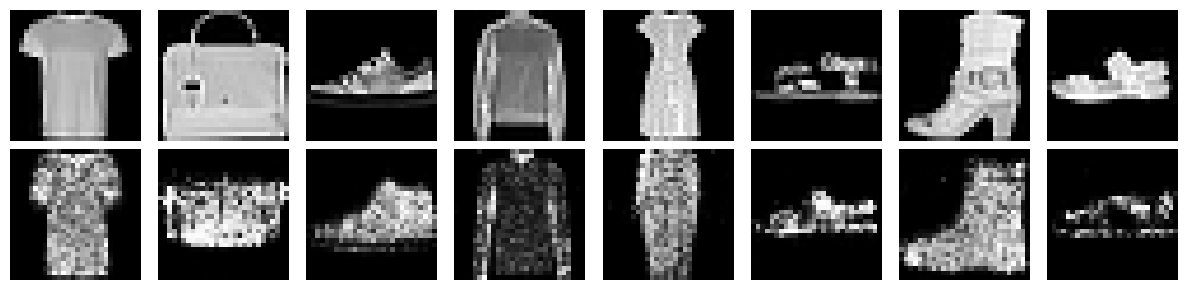

Epoch [76/100]  D loss: 0.6350  G loss: 1.0831  D acc: 0.6406
Epoch [77/100]  D loss: 0.6486  G loss: 0.8940  D acc: 0.5938
Epoch [78/100]  D loss: 0.6210  G loss: 0.8520  D acc: 0.6719
Epoch [79/100]  D loss: 0.5924  G loss: 0.6498  D acc: 0.6719
Epoch [80/100]  D loss: 0.6779  G loss: 0.6841  D acc: 0.6250


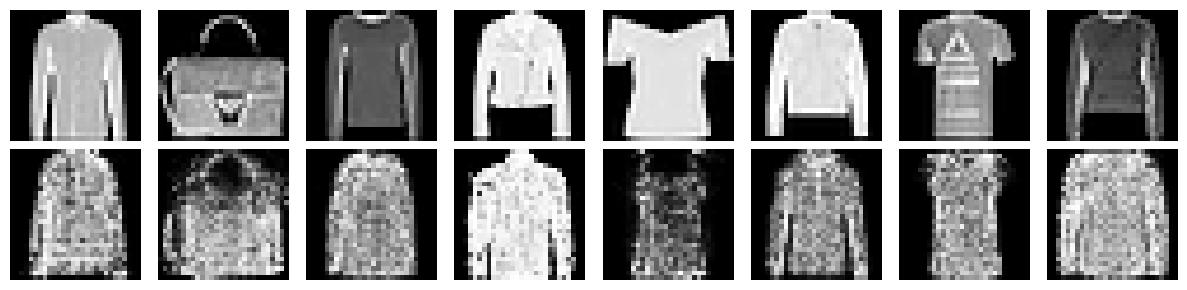

Epoch [81/100]  D loss: 0.7168  G loss: 1.1141  D acc: 0.5469
Epoch [82/100]  D loss: 0.6069  G loss: 0.8769  D acc: 0.6562
Epoch [83/100]  D loss: 0.6130  G loss: 0.8137  D acc: 0.7656
Epoch [84/100]  D loss: 0.6220  G loss: 0.9692  D acc: 0.7031
Epoch [85/100]  D loss: 0.6296  G loss: 1.0030  D acc: 0.6094


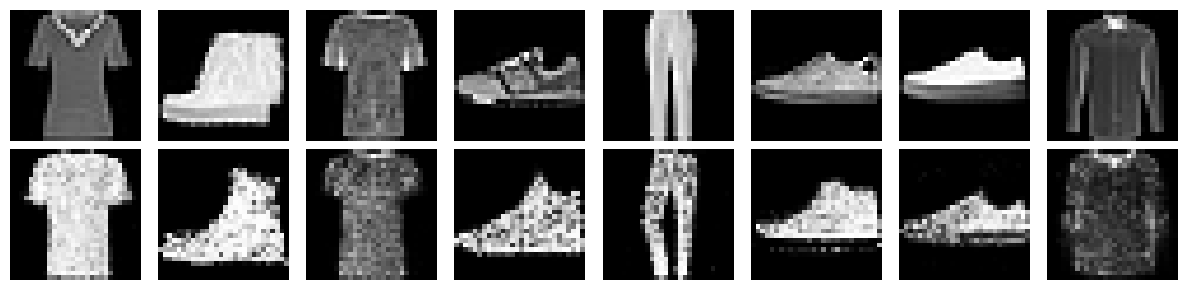

Epoch [86/100]  D loss: 0.6502  G loss: 0.9245  D acc: 0.6406
Epoch [87/100]  D loss: 0.6269  G loss: 1.0224  D acc: 0.6719
Epoch [88/100]  D loss: 0.6924  G loss: 0.9712  D acc: 0.5625
Epoch [89/100]  D loss: 0.6290  G loss: 0.5728  D acc: 0.6719
Epoch [90/100]  D loss: 0.7319  G loss: 0.7058  D acc: 0.4531


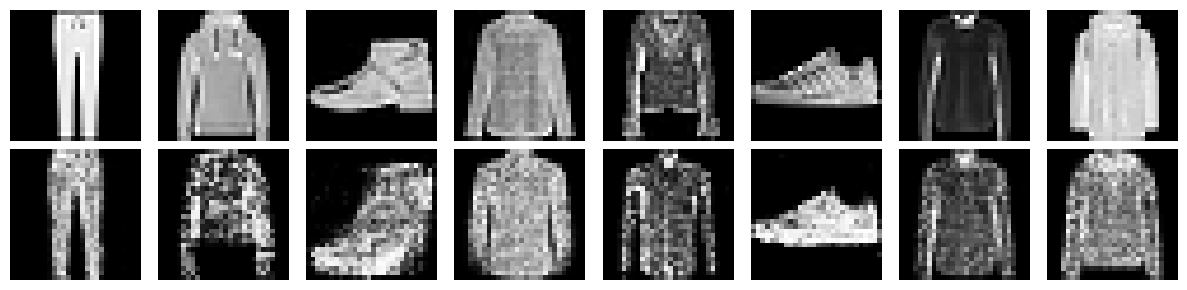

Epoch [91/100]  D loss: 0.6059  G loss: 1.2163  D acc: 0.6719
Epoch [92/100]  D loss: 0.7231  G loss: 1.2887  D acc: 0.5156
Epoch [93/100]  D loss: 0.7571  G loss: 0.8348  D acc: 0.5469
Epoch [94/100]  D loss: 0.6905  G loss: 0.8492  D acc: 0.6250
Epoch [95/100]  D loss: 0.6282  G loss: 1.2355  D acc: 0.6250


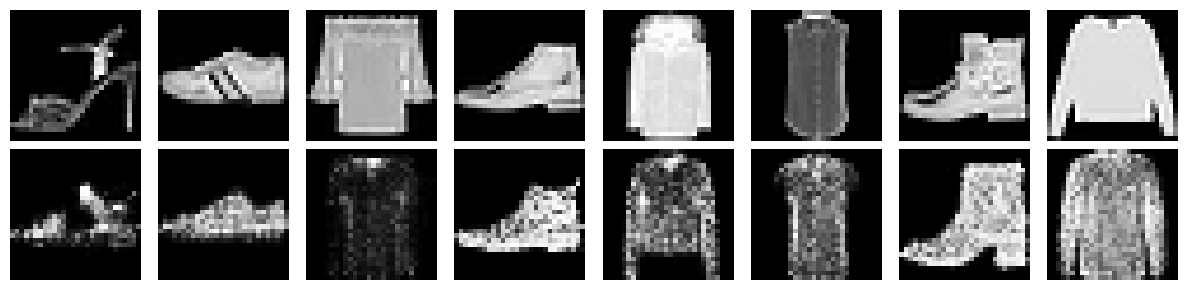

Epoch [96/100]  D loss: 0.6616  G loss: 0.7774  D acc: 0.5938
Epoch [97/100]  D loss: 0.6380  G loss: 1.0424  D acc: 0.6250
Epoch [98/100]  D loss: 0.6885  G loss: 1.2233  D acc: 0.5625
Epoch [99/100]  D loss: 0.5776  G loss: 1.2592  D acc: 0.6719
Epoch [100/100]  D loss: 0.6341  G loss: 1.0641  D acc: 0.6562


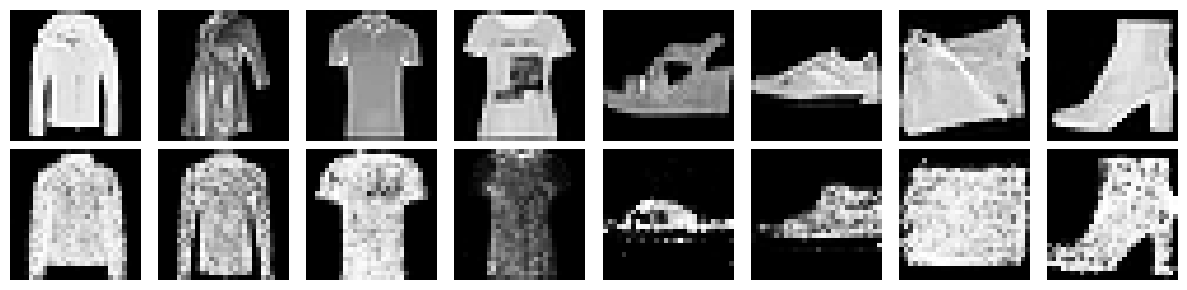

In [16]:
for epoch in range(epochs):
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        batch_size = imgs.size(0)

        real = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        noise = torch.randn(batch_size, latent_dim, device=device)
        fake_labels = torch.randint(0, n_classes, (batch_size,), device=device)
        fake_imgs = G(noise, fake_labels)

        real_output = D(imgs, labels)
        fake_output = D(fake_imgs.detach(), fake_labels)

        real_loss = criterion(real_output, real)
        fake_loss = criterion(fake_output, fake)
        d_loss = (real_loss + fake_loss) / 2

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Discriminator Accuracy 계산
        real_preds = (real_output > 0.5).float()
        fake_preds = (fake_output < 0.5).float()
        accuracy = (real_preds.sum() + fake_preds.sum()) / (2 * batch_size)

        # -----------------
        #  Train Generator
        # -----------------
        noise = torch.randn(batch_size, latent_dim, device=device)
        gen_labels = torch.randint(0, n_classes, (batch_size,), device=device)
        gen_imgs = G(noise, gen_labels)
        g_output = D(gen_imgs, gen_labels)
        g_loss = criterion(g_output, real)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    # 매 에폭마다 loss/accuracy 기록
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    d_accuracies.append(accuracy.item())

    print(f"Epoch [{epoch+1}/{epochs}]  D loss: {d_loss.item():.4f}  G loss: {g_loss.item():.4f}  D acc: {accuracy.item():.4f}")


    if (epoch + 1) % 5 == 0:
        G.eval()
        with torch.no_grad():
            noise = torch.randn(batch_size, latent_dim, device=device)
            sample_labels = labels[:batch_size].to(device)  # 원본 레이블 재사용
            fake_imgs = G(noise, sample_labels)
            show_real_fake(imgs, fake_imgs)
        G.train()

In [17]:
def plot_losses_and_accuracy(g_losses, d_losses, d_accuracies):
    epochs_range = range(1, len(g_losses) + 1)
    plt.figure(figsize=(14, 5))

    # Generator / Discriminator Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, g_losses, label='Generator Loss', color='green')
    plt.plot(epochs_range, d_losses, label='Discriminator Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Discriminator Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, d_accuracies, label='Discriminator Accuracy', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Discriminator Accuracy over Epochs')
    plt.ylim(0, 1)
    plt.legend()

    plt.tight_layout()
    plt.show()

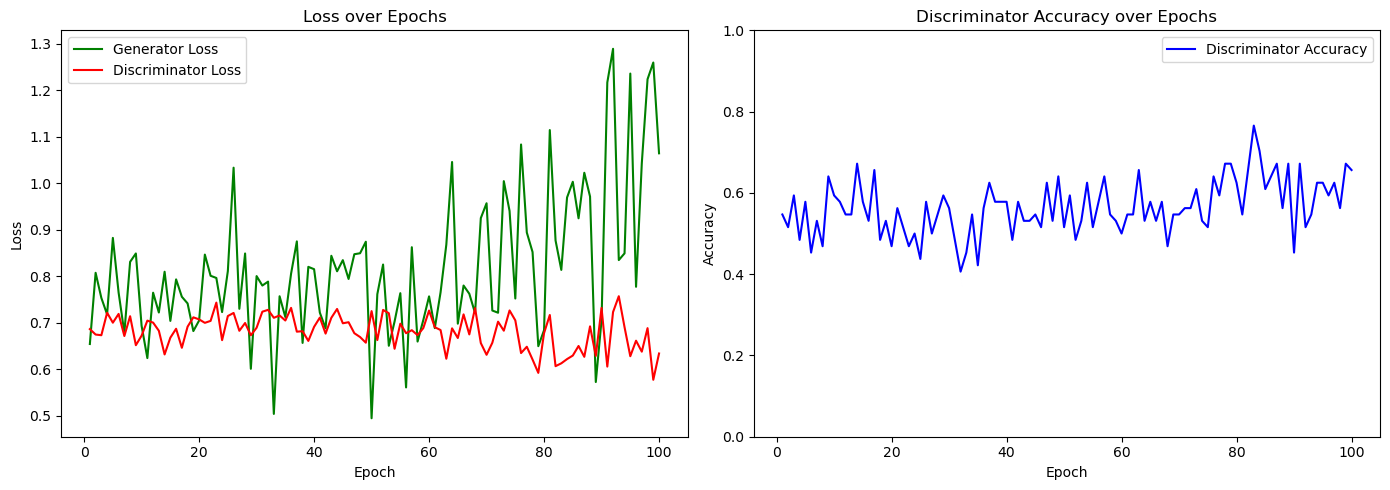

In [18]:
plot_losses_and_accuracy(g_losses, d_losses, d_accuracies)

### 결과
##### Generator Loss가 점차 증가하는 경향
→ 생성기가 discriminator를 속이기 점점 더 어려워지고 있음을 나타낸다. 이는 학습이 잘 안 되고 있을 가능성이 있으며, training instability를 시사할 수 있다.

##### Discriminator Loss가 비교적 안정적으로 유지
→ 약 0.65~0.75 사이에서 움직이고 있으며, discriminator가 어느 정도 안정적으로 작동하고 있음을 의미한다.

##### Loss의 전반적인 진동 존재
→ GAN 학습에서는 일반적으로 진동이 존재할 수 있지만, generator loss의 변동 폭이 점점 커지는 것은 주의가 필요하다. 이는 mode collapse 또는 학습 불안정성의 초기 징후일 수 있다고 생각한다.

-----------------------------------------

##### Accuracy가 약 0.5~0.7 사이를 유지
→ Discriminator가 어느 정도 real/fake를 구분하고 있지만, 완전히 구별하지는 못하고 있다는 뜻입니다. 이는 오히려 적당한 경쟁 구도가 형성되어 있다 좋은 신호일 수 있다고 생각한다.

##### 극단적으로 1에 가깝지 않음
→ Discriminator가 너무 강해져서 generator가 아무 것도 배우지 못하는 상황은 아닌 것으로 보여진다.